# LEPL1106, Devoir 4 : série de Fourier

## 0) Introduction

*Actuellement en pleine préparation de son prochain album, "Step Kronecker Impulsion", le rappeur 20 Cent est débordé et a besoin de votre aide. En effet, le beat d'une de ses chansons ne lui convient pas ; il souhaite booster les basses fréquences (fréquences graves) pour donner plus de "volume" au son. Pour cela, il souhaite dans un premier temps analyser le contenu fréquentiel du signal audio de son beat, pour ensuite, à partir de cette représentation, augmenter les composantes du signal associées aux basses fréquences. Il souhaite donc que vous l'aidiez à calculer les coefficients en série de Fourier d'un signal périodique.*

Pour rappel, la série de Fourier (FS) d'un signal discret périodique $x[n]$ de période fondamentale $N$ est donnée par :

$$X[k] = \frac{1}{N}\sum_{n=0}^{N-1} x[n] e^{-jk\Omega_0n} \qquad \qquad k\in 0,1,...,N-1$$

où $\Omega_0 = \frac{2\pi}{N}$. Les coefficients $X[k]$ obtenus sont également périodiques, de période fondamentale $N$ (c'est-à-dire, $X[k+N] = X[k]$, *vérifiez-le !*)

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Tailles de police utilisées avec la librairie matplotlib
legendsize = 14
titlesize = 14
labelsize = 16

## 1) Transformée de Fourier discrète (DFT en anglais) et Fast Fourier Transform (FFT)

Sans surprise, il existe une fonction intégrée à [NumPy](http://www.numpy.org/) qui réalise "presque" le calcul de la série de Fourier : il s'agit de la fonction [FFT](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html). Voyons de suite son docstring :

In [15]:
help(np.fft.fft) #Notez que la fonction fft se trouve dans le module fft de numpy, d'où np.fft.fft

Help on _ArrayFunctionDispatcher in module numpy.fft:

fft(a, n=None, axis=-1, norm=None)
    Compute the one-dimensional discrete Fourier Transform.
    
    This function computes the one-dimensional *n*-point discrete Fourier
    Transform (DFT) with the efficient Fast Fourier Transform (FFT)
    algorithm [CT].
    
    Parameters
    ----------
    a : array_like
        Input array, can be complex.
    n : int, optional
        Length of the transformed axis of the output.
        If `n` is smaller than the length of the input, the input is cropped.
        If it is larger, the input is padded with zeros.  If `n` is not given,
        the length of the input along the axis specified by `axis` is used.
    axis : int, optional
        Axis over which to compute the FFT.  If not given, the last axis is
        used.
    norm : {"backward", "ortho", "forward"}, optional
        .. versionadded:: 1.10.0
    
        Normalization mode (see `numpy.fft`). Default is "backward".
       

Sur base du docstring, on constate que la fonction `np.fft.fft` calcule la transformée de Fourier discrète, surnommée DFT pour *Discrete Fourier Transform* en anglais (à ne pas confondre avec la DTFT - *Discrete Time Fourier Transform* !). Pour ce faire, elle utilise l'algorithme *Fast Fourier Transform*$^1$ (FFT). Pour éviter toute confusion : la FFT est donc une *implémentation possible* (particulièrement efficace) de la DFT.


*$^1$ Pour les curieux, voir [Wikipédia](https://en.wikipedia.org/wiki/Fast_Fourier_transform) mais cela sort largement du cadre du cours. Retenez simplement que grâce à l'algorithme FFT, on peut calculer une DFT très rapidement _lorsque la longueur $N$ du signal fourni en entrée est une puissance de 2_*.


> Oui mais c'est quoi une DFT ?
>
> -- étudiant anonyme qui pensait avoir tout vu avec la séance 4

Une DFT permet d'évaluer numériquement les transformées (=/= séries) de Fourier. Sans rentrer dans trop de détails pour le moment, sachez que la définition de la DFT pour un signal $x[n]$ tronqué à $N$ échantillons est la suivante :

$$X_{DFT}[k] = \sum_{n=0}^{N-1} x[n] e^{-j2\pi kn/N} \qquad \qquad k\in 0,1,...,N-1$$

La DFT est aussi périodique, de période $N$ (soit $X_{DFT}[k+N]=X_{DFT}[k]$).

> Je me sens perdu avec toutes ces notions de transformées et séries !
>
> -- étudiant anonyme

Voici une petite synthèse de ces concepts, qui sont généralement utilisés pour passer de la représentation en domaine direct d'un signal à sa représentation en domaine fréquentiel :
 - FS (continu) : La Série de Fourier en temps continu ($x(t) \Rightarrow X[k]$) part d'un signal continu périodique;
 - FS (discret) : La Série de Fourier en temps discret ($x[n] \Rightarrow X[k]$) part d'un signal discret périodique;
 - FT : La Transformée de Fourier ($x(t) \Rightarrow X[j\omega]$) part d'un signal continu non-périodique;
 - DTFT : La Transformée de Fourier en temps discret ($x[n] \Rightarrow X(e^{j\Omega})$) part d'un signal discret non-périodique;
 - DFT : La Transformée de Fourier discrète ($x[n] \Rightarrow X[k]$) part d'un signal discret à **support fini**;
 - FFT : Il s'agit d'une implémentation possible pour calculer efficacement la DFT


Le concept de la DFT sera abordé lors du cours et une séance d'exercice complète lui est dédiée. Pas de panique si vous ne saisissez pas encore toutes les subtilités ! $^2$

Bref, outre un facteur $\frac{1}{N}$, DFT et FS (discret) semblent similaires pour des signaux discrets. La différence fondamentale réside dans l'interprétation implicite du $x[n]$ :

- Pour la DFT, le signal $x[n]$ est un signal à support fini, avec $N$ échantillons.

- Pour la FS, le signal $x[n]$ est périodique, de période $N$, et se répète donc en dehors des $N$ échantillons donnés à la FS. Généralement, on utilise une période du signal $x[n]$ pour calculer sa FS.

> Et donc je dois faire quoi pour mon devoir ???
>
> -- étudiant anonyme qui commence doucement à s'inquiéter

On va se restreindre ici à des signaux périodiques, de période $N$. On peut alors calculer leurs coefficients en série de Fourier (FS) simplement en calculant la DFT de taille $N$ (implémentée par l'*algorithme* FFT) et en corrigeant le facteur $\frac{1}{N}$ manquant dans la définition de la DFT par rapport à celle de la FS.

*$^2$ Pour celles et ceux qui voudraient mieux comprendre ou en savoir plus, n'hésitez pas à vous orienter vers le forum Moodle, votre tutrice/tuteur ou le reste de l'équipe encadrante.*

## 2) Calcul des coefficients de la série de Fourier d'un signal périodique

### Signal x[n]

Commençons par définir un petit cosinus de période $N=2$, auquel on somme une constante :

$$ x[n] = 2 + \cos(n \pi) $$

> Tiens donc, je me rappelle de ce signal... J'ai dû calculer les coefficients de sa série de Fourier lors de l'exercice 4.6 b) de la séance 4. Je vais donc pouvoir vérifier la réponse que j'obtiens ici avec celle que j'ai calculée en séance...
>
> -- étudiant anonyme plutôt malin

Petit test rapide pour voir à quoi ressemble notre signal :

n :  [0 1 2 3 4 5 6 7 8 9]
x :  [3. 1. 3. 1. 3. 1. 3. 1. 3. 1.]


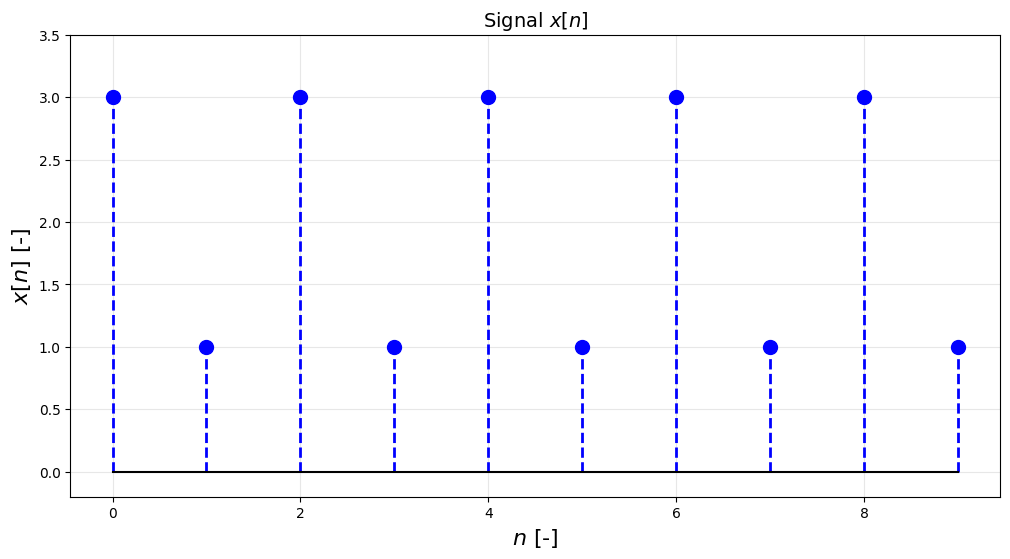

In [16]:
N = 2
n = np.arange(0,5*N)
x = 2 + np.cos(n*np.pi)

print("n : ",n)
print("x : ",x)

plt.figure(figsize=(12,6))
markerline, stemlines, baseline = plt.stem(n,x)
plt.setp(baseline,color='k')
plt.setp(stemlines,color='b',linewidth=2,linestyle='--')
plt.setp(markerline,color='b',marker='o',markersize=10)
plt.title(f"Signal $x[n]$",fontsize=titlesize)
plt.xlabel('$n$ [-]',fontsize=labelsize)
plt.ylabel('$x[n]$ [-]',fontsize=labelsize)
plt.grid('on',alpha=0.3)
plt.ylim((-0.2,3.5))
plt.show()

Comme attendu, le signal est bien périodique, de période $N=2$.

### Avez-vous bien suivi l'introduction théorique ?

Nous vous proposons de commencer le devoir par vous poser les questions suivantes, sur base de l'introduction théorique ci-dessus...

Le signal $x[n]$ est-il...
 - Discret ?
 - Continu ?
 - Périodique ?
 - Non-périodique ?

Après calcul des coefficients de Série de Fourier, le signal $X[k]$ sera-t-il...
 - Discret ?
 - Continu ?
 - Périodique ?
 - Non-périodique ?
 - Obtenu à l'aide d'une DTFT ?

Ce même signal $X[k]$ est-il une fonction...
 - Paire ?
 - Impaire ?
 - Ni paire ni impaire ?

Les réponses à ces questions devront être données sur INGInious.

### Calcul des coefficients de la série de Fourier

A vous d'implémenter maintenant la fonction `serieFourier(x,N)`, calculant les coefficients de la **série de Fourier** ($\neq$ DFT) d'un signal périodique $x[n]$.

L'argument $N$ est un entier et correspond à la période *fondamentale* du signal. L'argument $x$ est un vecteur de longueur $pN$ où $p\in \mathbb N$ et dont les entrées sont des valeurs réelles. Le support du signal $x$ est donc $\{0,\dots,pN-1\}$.

La fonction doit renvoyer deux vecteurs $X$ et $k$ décrits ci-dessous (attention à bien retourner le tuple $(X,k)$).
Le vecteur $X$, __de longueur $N$__, contient les coefficients de Fourier du signal périodique $x[n]$ __calculés sur une seule période__, ceux-ci pouvant être complexes. Le vecteur $k$ contient les indices (entiers relatifs) correspondant aux coefficients  $X$ de la série de Fourier.

Attention, on vous demande en outre de :

- supprimer les erreurs d'arrondis en remplaçant par 0 les coefficients $X[k]$ ayant une **amplitude en valeur absolue** inférieure à 1e-9

- centrer les coefficients $X[k]$ obtenus autour de $k=0$ (ce qui correspond à la fréquence nulle). Pour ce faire, utilisez la fonction `np.fft.fftshift` (voir [ici](https://numpy.org/doc/stable/reference/generated/numpy.fft.fftshift.html)), qui s'utilise directement sur la sortie de la fonction `np.fft.fft`. Après avoir appliqué un `np.fft.fftshift`, le vecteur des $k$ ne correspond plus à $\{0,1,...,N-1\}$ mais bien à l'intervalle [(c'est quoi ces parenthèses malformées ?)](https://fr.wikipedia.org/wiki/Partie_enti%C3%A8re_et_partie_fractionnaire)
 :
$$k\in\left\{-\left\lceil{\frac{N-1}{2}}\right\rceil,\dots,\left\lfloor{\frac{N-1}{2}}\right\rfloor\right\}.$$
A vous de construire correctement ce vecteur des $k$ en toute généralité, votre fonction sera testée sur d'autres signaux.


In [17]:
## LE CONTENU DE CETTE CELLLULE EST A SOUMETTRE SUR INGINIOUS

def serieFourier(x,N):
    """
    Calcule les coefficients de la série de Fourier d'un signal périodique x[n].

    Arguments
    ---------
    x : array-like
        Vecteur de longueur pN représentant le signal périodique.
        Les valeurs doivent être réelles.
    N : int
        Période fondamentale du signal.

    Retourne
    --------
    tuple: Un tuple (X, k) contenant les coefficients de Fourier et les indices
    X : ndarray (size N)
        numpy array contenant les coefficients de Fourier du signal périodique x[n], calculés sur une seule période
    k : ndarray
        numpy array des indices correspondant aux coefficients X de la série de Fourier, centrés autour de k=0

    Notes
    -----
    Les coefficients X[k] ayant une amplitude en valeur absolue inférieure à 1e-9 sont remplacés par 0 pour éviter les erreurs d'arrondis
    """
    # Récupération des valeurs de la fft dans fX
    fX = np.fft.fftshift(np.fft.fft(x,n=N))

    # Rectification des erreurs d'arrondis
    X = np.array([fX[i] if np.abs(fX[i])>1e-9 else 0 for i in range(len(fX))])

    # Création de k basée sur la formule donnée
    k = np.arange(-np.ceil((N-1)/2),np.floor((N-1)/2)+1)
    
    return (X,k)


In [18]:
## CELLULE DE TEST

# Création du signal période x[n], sur une seule période
N = 2
p = 2 # à modifier
n = np.arange(0,p*N)
x  = 2 + np.cos(n*np.pi) # signal de l'exercice 4.6 b)


(X,k) = serieFourier(x,N)

print("k :  ", k)
print("Module de X :", np.abs(X))

# Vous devez normalement obtenir ici la même valeur que les coefficients calculés à l'exercice 4.6 b). Sauf que, suite au
# fftshift, vous obtenez X[-1] et X[0]. Cela étant, les coefficients X[k] étant périodiques de période N=2, on a X[-1]=X[1].

# Testez maintenant de modifier p pour prendre p périodes fondamentales du signal x[n].
# Votre fonction remplit-elle les spécifications demandées ? (vecteur X de longueur N ?...)

k :   [-1.  0.]
Module de X : [2. 4.]


## 3) Représentation des coefficients en série de Fourier

Finalement, on aimerait représenter les coefficients en série de Fourier sur une figure. Pour cela, nous vous proposons de compléter la fonction `plotSerieFourier(x,X,k,name)` qui crée et sauvegarde une figure contenant trois sous-figures affichant, dans l'ordre : 1) le signal discret $x[n]$ aux indices $n$ appropriés, 2) le graphe en amplitude et 3) le graphe en phase des coefficients $X[k]$ aux indices $k$ appropriés (rappelez-vous, les coefficients $X[k]$ de la série de Fourier peuvent être complexes en toute généralité, d'où l'utilité de créer un graphe en amplitude et en phase). Pour représenter les 3 sous-figures, utilisez la librairie Matplotlib avec la fonction [subplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html).

Votre fonction sauve également la figure au format png (donc un seul fichier pour les 3 sous-figures) avec le nom *name* (la sauvegarde est déjà implémentée pour vous, ne supprimez pas cette ligne !). Faites attention à respecter la convention d'affichage d'un signal discret (par exemple, en utilisant *plt.stem*), à annoter convenablement vos axes (labels, unités...), et à donner un titre et (si besoin) une légende à vos sous-figures.

In [19]:
# LE CONTENU DE CETTE CELLLULE EST A SOUMETTRE SUR INGINIOUS

def plotSerieFourier(x, X, k, name):
    """
    Crée et sauvegarde une figure représentant les coefficients en série de Fourier.

    Cette fonction crée une figure avec trois sous-figures :
        1) Le signal discret x[n] aux indices n appropriés,                                 \n
        2) Le graphe en amplitude des coefficients X[k] aux indices k appropriés,           \n
        3) Le graphe en phase des coefficients X[k] aux indices k appropriés.

    Les coefficients X[k] de la série de Fourier peuvent être complexes, d'où l'utilité
    de créer un graphe en amplitude et en phase.

    Arguments
    ---------
    x : array-like
        Vecteur représentant le signal discret x[n]
    X : array-like
        Vecteur contenant les coefficients de Fourier X[k]
    k : array-like
        Vecteur des indices correspondant aux coefficients X
    name : str
        Nom du fichier png pour sauvegarder la figure

    Notes
    -----
    La figure est sauvegardée au format png dans le même dossier que ce code-ci.
    """
    # Création de la figure et des sous-figures
    plt.figure(figsize=(12, 8))

    # Subplot 1 : Signal discret x[n]
    plt.subplot(3, 1, 1)

    _, _, baseline = plt.stem(np.arange(len(x)), x)
    baseline.set_color('k')
    baseline.set_linewidth(1)
    
    plt.title('Signal discret $x[n]$')
    plt.xlabel('n')
    plt.ylabel('$x[n]$')

    # Subplot 2 : Graphe en amplitude des coefficients X[k]
    plt.subplot(3, 1, 2)

    _, _, baseline = plt.stem(k, np.abs(X))
    baseline.set_color('k')
    baseline.set_linewidth(1)

    plt.title('Graphe en amplitude des coefficients X[k]')
    plt.xlabel('k')
    plt.ylabel('Amplitudes')

    # Subplot 3 : Graphe en phase des coefficients X[k]
    plt.subplot(3, 1, 3)

    _, _, baseline = plt.stem(k, np.angle(X))
    baseline.set_color('k')
    baseline.set_linewidth(1)

    plt.title('Graphe en phase des coefficients X[k]')
    plt.xlabel('k')
    plt.ylabel('Radians')

    # Ajustement de l'espacement entre les sous-figures
    plt.tight_layout()

    # Sauvegarde de la figure au format png
    plt.savefig(name + '.png')

    # Affichage de la figure
    plt.show()

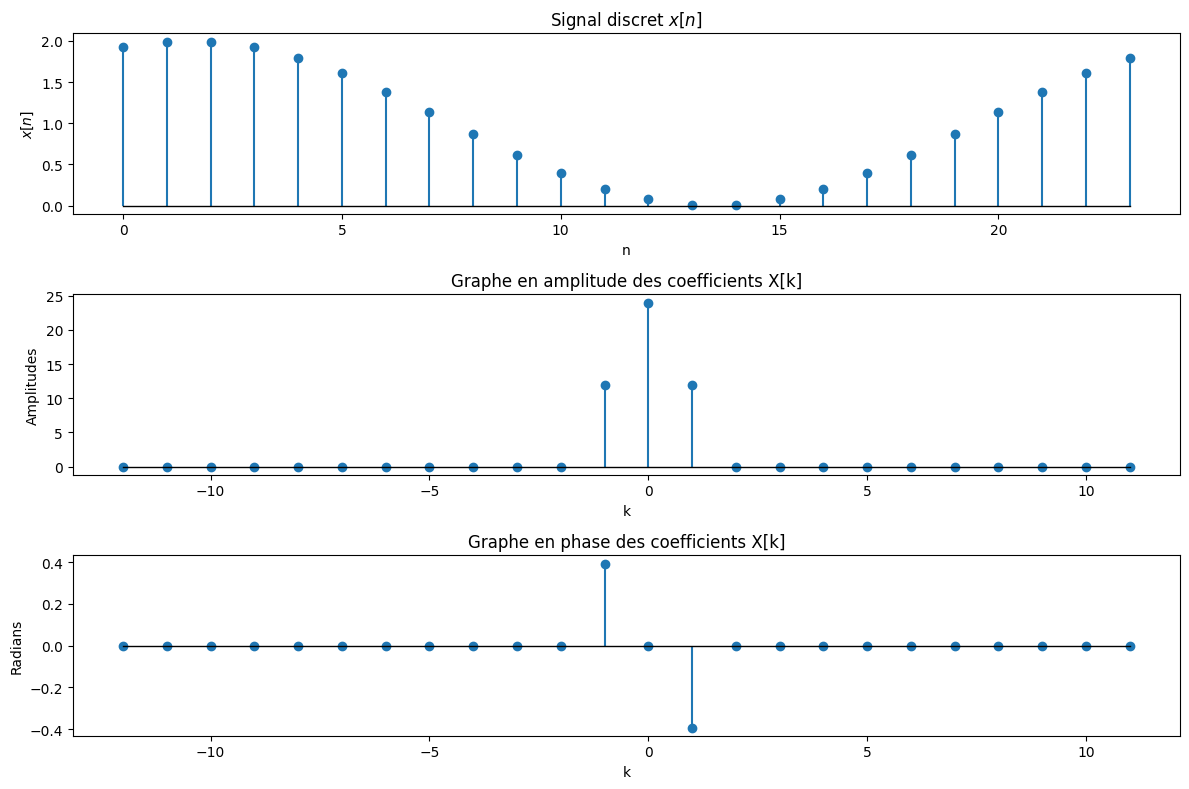

In [20]:
## CELLULE DE TEST

# Création du signal période x[n], sur une seule période
N = 24
p = 1 # à modifier
n = np.arange(0,p*N)
x  = 1 + np.sin(n*np.pi/12 + 3*np.pi/8) # signal de l'exercice 4.6 c), vérifiez donc avec ce que vous avez calculé !

(X,k) = serieFourier(x,N)

plotSerieFourier(x,X,k,"test")